In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('../ParticleDataTool/')
from impy import common, sibyll, urqmd_module
import numpy as np

This example demonstrates how to use the simplified classes *CascadeRun*. The CascadeRun classes are used for the generation of MCEq tables. The purpose is:

    1) Initialise the interaction model for variable energy up to the highest cosmic ray energies
    2) Run the generator as a function of Elab for a pre-defined number of events.
    3) Histogram each type of particle (separated) of the energy spectrum in lab frame.
    

In [2]:
urqmd_run = urqmd_module.UrQMDCascadeRun(
    #
    lib_str = 'urqmd',
    label = 'UrQMD 3.4',
    # Set groups of particles stable: 
    # 1 is just basics (pions, muons,neutron..), 
    # 2 (similar to LHC 10ps definition)
    # 3 (all kinds of strange mesons and baryons stable)
    # 4 (all particles stable)
    decay_mode = 0,
    p_debug=True,
    # ...
    n_events=10000,
    # Don't raise an exception of the no histrogram for some particle type is not found
    fill_subset=True,
    
#     evt_class=urqmd_module.UrQMDCascadeEvent
)


UrQMDCascadeRun::set_stable(): Setting standard particles stable.
stable, 211
stable, 321
stable, 2212
stable, 2112
stable, 3122
stable, 411
stable, 421
stable, 431
stable, -211
stable, -321
stable, -2212
stable, -2112
stable, -3122
stable, -411
stable, -421
stable, -431
stable, 111
stable, 221
stable, 223
stable, 333
UrQMDCascadeRun::init_generator(): Done


The class expects a somewhat different type of historgrams. Below are some definitions from the "m2m" (Model-to-Matrix)  package.

In [3]:
class Histogram():
    def __init__(self, title, x_bins):
        self.title = title
        
        self.x_bins = x_bins
        self.n_bins = len(x_bins) - 1
        self.widths = self.x_bins[1:] - self.x_bins[:-1]
        
        self.values = np.array(np.zeros(self.n_bins), dtype='d')
        self.n_entries = 0
        
        # Buffer 10^5 entries before running np.histogram
        self.s_buf = int(1e5)
        self.buffer = np.zeros(self.s_buf, dtype='d')
        self.last_idx = 0
        self.n_events_filled = 0
        

    def fill_event(self, event_series):
        s_entr = event_series.size
        if self.last_idx + s_entr < self.s_buf:
            self.buffer[self.last_idx:self.last_idx + s_entr] = event_series
            self.last_idx = self.last_idx + s_entr
        else:
            self.values += np.histogram(self.buffer[:self.last_idx],
                                        self.x_bins)[0]
            self.last_idx = 0
            
        self.n_entries += 1.
    
    def flush(self):
        if self.last_idx > 0:
            try:
                self.values += np.histogram(self.buffer[:self.last_idx],
                                        self.x_bins)[0]
            except:
                pass
        self.last_idx = 0

    def get(self):
        self.flush()
        return self.values / self.widths / float(self.n_events_filled)

    def __iadd__(self, other):
        if not bool(np.alltrue(self.x_bins == other.x_bins)):
            raise Exception("Histogram():: Trying to add histograms with different" + 
                            " binning.")
                                    
        self.values += other.values
        self.n_entries += other.n_entries
        self.n_events_filled += other.n_events_filled
        return self

    def __getstate__(self):
        try:
            self.flush()
            del self.buffer
        except TypeError:
            pass
        return self.__dict__

    def __setstate__(self, state):
        self.__dict__ = state
        self.buffer = None

class EnergySpectrum(Histogram):
    def __init__(self, part_id, pdg_id, E_lab, 
        grid_var, **kwargs):
        Histogram.__init__(self, **kwargs)
        
        self.particle_id = part_id
        self.pdg_id = pdg_id
        self.E_lab = E_lab
        if grid_var == 'E':
            self.scale = 1.
        elif grid_var == 'x':
            self.scale = self.E_lab
        
    def fill_event(self, event):
        event_series = event.E[np.where(
            event.p_ids == self.particle_id)]/self.scale
        Histogram.fill_event(self, event_series)



class EnergySpectrumBoost(EnergySpectrum):
    def __init__(self, lorentz_factors, **kwargs):
        self.gamma, self.beta_gamma = lorentz_factors
        EnergySpectrum.__init__(self, **kwargs)
        
    def fill_event(self, event):
        sel = np.where(event.p_ids == self.particle_id)
        event_series = (self.gamma * event.E[sel] + 
            self.beta_gamma * event.pz[sel])/self.scale
        Histogram.fill_event(self, event_series)


In [4]:
# Normal interaction p + N
evkin = common.EventKinematics(plab=80, p1pdg=2212, nuc2_prop=(14,7))

In [5]:
# Put some histrograms 
urqmd_run.spectrum_hists = []
pdt = urqmd_run.ptab
for pdgid in [211, -211, 321, -321, 2212, 2112]:
    urqmd_run.spectrum_hists.append(
        EnergySpectrumBoost(lorentz_factors=(evkin.gamma_cm, evkin.betagamma_cm),
                        part_id = pdgid,#pdt.pdg2modid[pdgid],
                        pdg_id = pdgid,
                        E_lab=evkin.elab,
                        title = pdt.pdg2modname[pdgid],
                        grid_var = 'x',
                        x_bins=np.logspace(-5,1,100))
    )

In [6]:
urqmd_run.start(evkin, 1)

1000 events generated.
2000 events generated.
3000 events generated.
4000 events generated.
5000 events generated.
6000 events generated.
7000 events generated.
8000 events generated.
9000 events generated.


In [7]:
%timeit urqmd_run.lib.urqmd(1)

The slowest run took 39.25 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.67 ms per loop


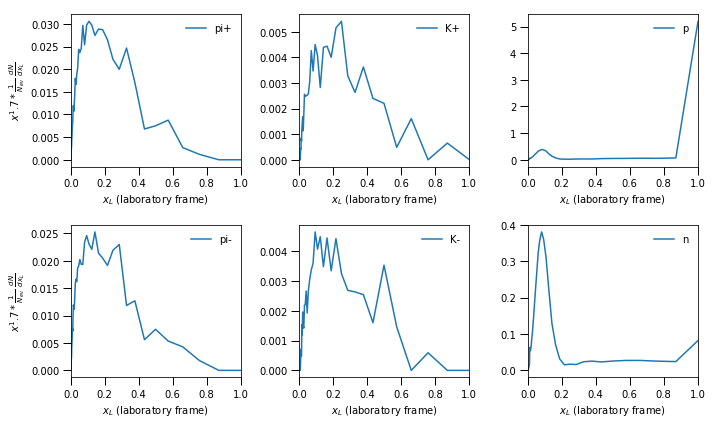

In [8]:
fig, axes = plt.subplots(2,3,figsize=(10,6))

for ih, h in enumerate(urqmd_run.spectrum_hists):
    xcenters = 0.5*(h.x_bins[1:] + h.x_bins[:-1]) 
    ax = axes.T.flatten()[ih]
    ax.plot(xcenters, 
               xcenters**1.7*h.get(), 
                 label=h.title)
    ax.set_xlabel(r'$x_L$ (laboratory frame)')
    if ih in [0,1]:
        ax.set_ylabel(r'$x^1.7*\frac{1}{N_{ev}}$ $\frac{dN}{dx_L}$')
    ax.legend()
    ax.set_xlim(1e-5,1)
plt.tight_layout()

In [9]:
sibyll_run = sibyll.SibyllCascadeRun(
    #
    lib_str = 'sib23c',
    label = 'Sibyll 2.3c',
    # Set groups of particles stable: 
    # 1 is just basics (pions, muons,neutron..), 
    # 2 (similar to LHC 10ps definition)
    # 3 (all kinds of strange mesons and baryons stable)
    # 4 (all particles stable)
    decay_mode = 0,
    # ...
    n_events=10000,
    # Don't raise an exception of the no histrogram for some particle type is not found
    fill_subset=True,
    
#     evt_class=urqmd_module.UrQMDCascadeEvent
)



SibyllCascadeRun::set_stable(): Setting standard particles stable.
SibyllCascadeRun::init_generator(): seed= 2067709


In [10]:
# Put some histrograms 
sibyll_run.spectrum_hists = []
pdt = sibyll_run.ptab
for pdgid in [211, -211, 321, -321, 2212, 2112]:
    sibyll_run.spectrum_hists.append(
        EnergySpectrumBoost(lorentz_factors=(evkin.gamma_cm, evkin.betagamma_cm),
                        part_id = pdt.pdg2modid[pdgid],
                        pdg_id = pdgid,
                        E_lab=evkin.elab,
                        title = pdt.pdg2modname[pdgid],
                        grid_var = 'x',
                        x_bins=np.logspace(-5,1,100))
    )

In [11]:
sibyll_run.start('p',evkin.elab,evkin.ecm,Atarget=14)


        Model     : Sibyll 2.3c
        N_events  : 10000
        Projectile: p
        E_lab     : 8.001e+01 GeV
        E_cm      : 1.233e+01 GeV
        Target    : 14
        


In [12]:
%timeit sibyll_run.lib.sibyll(13,0,20.)

10000 loops, best of 3: 56.3 µs per loop


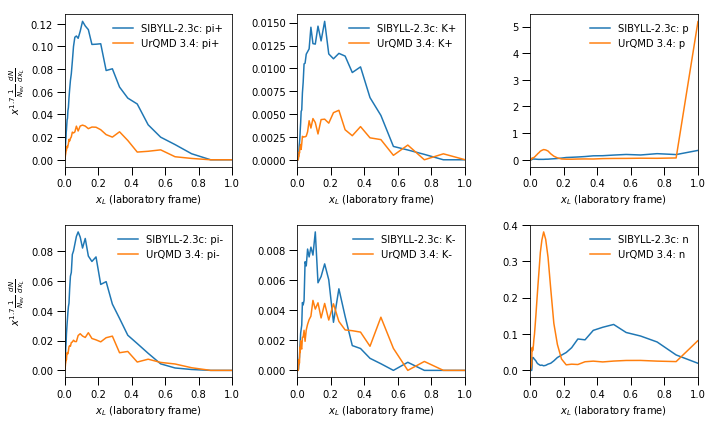

In [15]:
fig, axes = plt.subplots(2,3,figsize=(10,6))

for ih, (hu, hs) in enumerate(zip(urqmd_run.spectrum_hists, sibyll_run.spectrum_hists)):
    xcenters = 0.5*(h.x_bins[1:] + h.x_bins[:-1]) 
    ax = axes.T.flatten()[ih]
    lu = ax.plot(xcenters, 
               xcenters**1.7*hs.get(), 
                 label='SIBYLL-2.3c: ' + hs.title)
    ls = ax.plot(xcenters, 
               xcenters**1.7*hu.get(), 
                 label='UrQMD 3.4: ' + hu.title)
    ax.set_xlabel(r'$x_L$ (laboratory frame)')
    if ih in [0,1]:
        ax.set_ylabel(r'$x^{1.7}\frac{1}{N_{ev}}$ $\frac{dN}{dx_L}$')
    ax.legend()
    ax.set_xlim(1e-5,1)
plt.tight_layout()
plt.savefig('cmp_urqmd_sibyll_pN_80GeVlab.png',dpi=300)